Copyright (c) Microsoft Corporation. All rights reserved.
Licensed under the MIT License.

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import librosa
import librosa.display
import soundfile as sf
import audioread
import wave
import re
from collections import Counter
import cv2
import matplotlib
from matplotlib import pyplot as plt
import math
from joblib import Parallel, delayed
import multiprocessing
import gc
import random

import pickle as pk
import h5py
from fastprogress.fastprogress import progress_bar

import IPython.display as ipd
from IPython.display import Audio, display

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = os.path.join('train_audio')
extended_data_dir = os.path.join('train_extended') # extended data downloaded from Kaggle competition
dataDir = 'data'
resultsDir = 'Results'

# sampling_rate = 44100 # original
sampling_rate = 32000

if not os.path.exists(dataDir):
    os.makedirs(dataDir)
if not os.path.exists(resultsDir):
    os.makedirs(resultsDir)

In [20]:
train_metadata = pd.read_csv(os.path.join('train.csv'))
train_extended_metadata = pd.read_csv('train_extended.csv')

In [4]:
birds_species = [x.split('/')[-1] for x in glob.glob('train_audio/*')]
data_labels = {birds_species[i]:i for i in range(len(birds_species))}

In [ ]:
def get_audio(fname, sr):
    try:
        sx, sr = librosa.load(fname, sr=sr)
        print('ok')
        return sx
    except ZeroDivisionError as zer:
        print('0')
        return []
    except:
        print('d')
        return []
    
raw_audio_next = []
labels_next = []
num_cores = multiprocessing.cpu_count()
ctr_ = 0
meta_data = []
for specie, label in progress_bar(data_labels.items()):
    
    data_location = os.path.join(data_dir, specie)
    idx_use = train_metadata['ebird_code'] == specie
    metadata_specie = train_metadata.loc[idx_use]
    filenames = list(metadata_specie['filename'])
    samples_loc_list = [os.path.join(data_location, file) for file in filenames]

    if len(samples_loc_list)>=100:
        audio_ = Parallel(n_jobs=num_cores)(
                    delayed(get_audio)(fname, sampling_rate) 
                    for fname in samples_loc_list
                )
        raw_audio_next.extend(audio_)
        labels_next.extend([specie for _ in range(len(samples_loc_list))])  
        meta_data.append(metadata_specie)
        print(f'taking {specie}...')
    ctr_ += 1

In [9]:
meta_data = pd.concat(meta_data, sort=False).reset_index(drop=True)

In [ ]:
labels_freq = {a:labels_next.count(a) for a in labels_next}

In [33]:
labels_extended = list(train_extended_metadata['ebird_code'])
labels_freq_extended = {a:labels_extended.count(a) for a in labels_extended}

In [39]:
labels_freq_total = dict(labels_freq)
for key, val in labels_freq_extended.items():
    labels_freq_total[key] += val

In [43]:
max(labels_freq_total.values())

1778

In [44]:
max(labels_freq.values())

100

In [ ]:
def get_audio(fname, sr):
    try:
        sx, sr = librosa.load(fname, sr=sr)
        return sx
    except ZeroDivisionError as zer:
        return []
    except:
        return []
    
raw_audio_extended = []
labels_extended = []
metadata_extended = []
num_cores = multiprocessing.cpu_count()
ctr_ = 0

for specie in progress_bar(labels_freq.keys()):
    data_location = os.path.join(extended_data_dir, specie)
    idx_use = train_extended_metadata['ebird_code'] == specie
    metadata_specie = train_extended_metadata.loc[idx_use]
    filenames = list(metadata_specie['filename'])
    samples_loc_list = [os.path.join(data_location, file) for file in filenames]
        
    audio_ = Parallel(n_jobs=num_cores)(
                        delayed(get_audio)(fname, sampling_rate) for fname in samples_loc_list
            )
    raw_audio_extended.extend(audio_)
    labels_extended.extend([specie for _ in range(len(samples_loc_list))])
    metadata_extended.append(metadata_specie)

In [ ]:
metadata_extended = pd.concat(metadata_extended, sort=False).reset_index(drop=True)

In [15]:
# possible empty data in the extended dataset
idx_pop = []
for ii, audio in enumerate(raw_audio_extended):
    if len(audio)==0:
        idx_pop.append(ii)

raw_audio_extended = [audio for ii, audio in enumerate(raw_audio_extended) if ii not in idx_pop]
labels_extended = [lbl for ii, lbl in enumerate(labels_extended) if ii not in idx_pop]
metadata_extended = metadata_extended.drop(idx_pop).reset_index(drop=True)

In [17]:
raw_audio_next.extend(raw_audio_extended)
labels_next.extend(labels_extended)

In [13]:
metadata_total = pd.concat([meta_data, metadata_extended], sort=False).reset_index(drop=True)

Savecloseaudio

In [ ]:
file_name = 'birds_cornell_audio_100_species_sr_32000.h5'
hf = h5py.File(os.path.join(dataDir,
                file_name), 'w')
grp = hf.create_group('raw_audio')
for ii, audio in enumerate(raw_audio_next):
    grp.create_dataset(np.str(ii), data = audio)

hf.create_dataset('sr', data=sampling_rate)
hf.close()
metadata_total.to_hdf(os.path.join(dataDir,
            file_name), key='info')

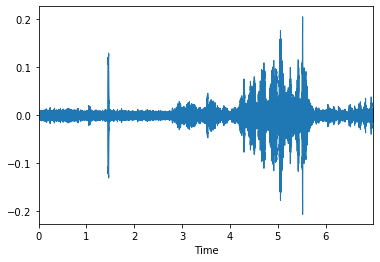

In [80]:
librosa.display.waveplot(raw_audio_next[0][:7*sampling_rate], sr=sampling_rate)

# Spectrograms

In [65]:
labels = np.unique(metadata_extended['ebird_code'])
spectr_time_len = 7
idx_use = []
ctr = 0
for lbl in labels:
    idx_label = metadata_extended.loc[metadata_extended['ebird_code'] == lbl].index
    useful = []
    for ii in idx_label:
        if len(raw_audio_extended[ii])>=spectr_time_len*sampling_rate:
            useful.append(ii)
    if len(useful)>20:
        idx_use.extend(useful)
        ctr += 1
    if ctr == 100:
        break
metadata_clipped = metadata_extended.loc[idx_use].reset_index(drop=True)
clipped_audio = []
for idx in idx_use:
    clipped_audio.append(raw_audio_extended[idx][:spectr_time_len*sampling_rate])

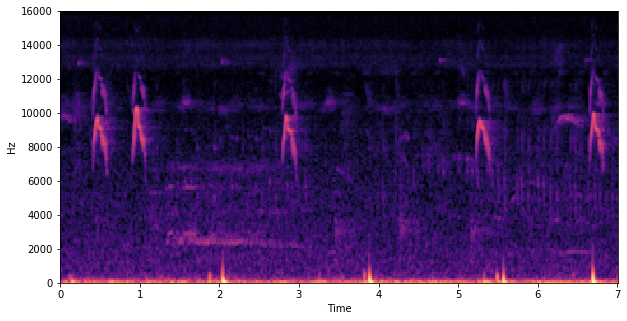

In [89]:
plt.figure(figsize=(10, 5))
S = librosa.feature.melspectrogram(
            y = clipped_audio[1],
            sr = sampling_rate,
            n_mels=128,
    )
            # flip is done across vertically to make lower frequencies in the bottom part, as done
            # by the liborsa specshow
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='hz', sr = sampling_rate)
plt.show()

# get spectrograms

In [68]:
def get_spectr(audio, sampling_rate):
    S = librosa.feature.melspectrogram(
            y = audio,
            sr = sampling_rate,
            n_mels=128,
    )
            # flip is done across vertically to make lower frequencies in the bottom part, as done
            # by the liborsa specshow
    return np.flip(librosa.power_to_db(S, ref=np.max).astype('float32'), axis=0)

In [69]:
num_cores = multiprocessing.cpu_count()
spectr_clipped = Parallel(n_jobs=num_cores)(
                            delayed(get_spectr)(audio, sampling_rate)
                            for audio in clipped_audio
                )

In [70]:
spectr_clipped = np.array(spectr_clipped)

In [72]:
file_name = f'birds_cornell_spectr_100_species_sr_32000_len_{spectr_time_len}_sec_New.h5'
hf = h5py.File(os.path.join(dataDir,
                file_name), 'w')
grp = hf.create_dataset('mel_spectr', data=spectr_clipped)
hf.close()
metadata_clipped.to_hdf(os.path.join(dataDir,
            file_name), key='info')

# Sliding window spectrograms

In [73]:
win_len = 500 # in ms
win_slide_len = 250 # in ms

In [74]:
def get_sliding_spectr(full_audio, win_len, win_slide_len, sampling_rate):
    num_windows_max_possible = int((7000-win_len)/win_slide_len)

    win_ind = 0
    spectr_try = get_spectr(full_audio[win_ind*int(win_slide_len/1000*sampling_rate):win_ind*int(win_slide_len/1000*sampling_rate)+int(win_len/1000 * sampling_rate)],
                                                 sampling_rate)
    spectr_slides = np.empty((num_windows_max_possible, np.shape(spectr_try)[0], np.shape(spectr_try)[1]))
    for win_ind in range(num_windows_max_possible):
        spectr_slides[win_ind,:] = get_spectr(full_audio[win_ind*int(win_slide_len/1000*sampling_rate):win_ind*int(win_slide_len/1000*sampling_rate)+int(win_len/1000 * sampling_rate)],
                                                 sampling_rate)
    return spectr_slides
    
num_cores = multiprocessing.cpu_count()

spectr_clipped_slide = Parallel(n_jobs=num_cores)(
                            delayed(get_sliding_spectr)(audio, win_len, win_slide_len, sampling_rate) 
                            for audio in clipped_audio)

In [75]:
spectr_clipped_slide = np.array(spectr_clipped_slide)

In [76]:
file_name = f'birds_cornell_spectr_slide_100_species_sr_32000_len_{spectr_time_len}_sec_{win_len}_{win_slide_len}_New.h5' 
hf = h5py.File(os.path.join(dataDir,
                file_name), 'w')
grp = hf.create_dataset('mel_spectr', data=spectr_clipped_slide)
hf.close()
metadata_clipped.to_hdf(os.path.join(dataDir,
            file_name), key='info')

# test

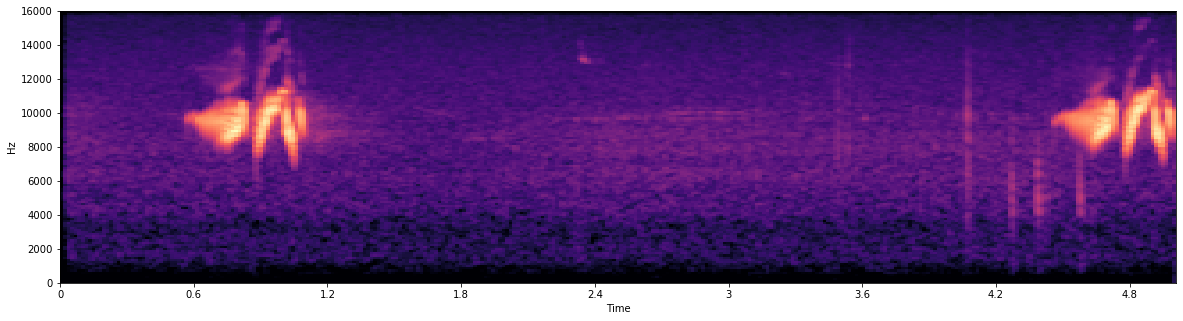

In [29]:
idx_spectr = 10
plt.figure(figsize=(20, 5))
S = np.flipud(spectr_clipped[idx_spectr])
librosa.display.specshow(S, x_axis='time', y_axis='hz', sr = sampling_rate)
plt.show()

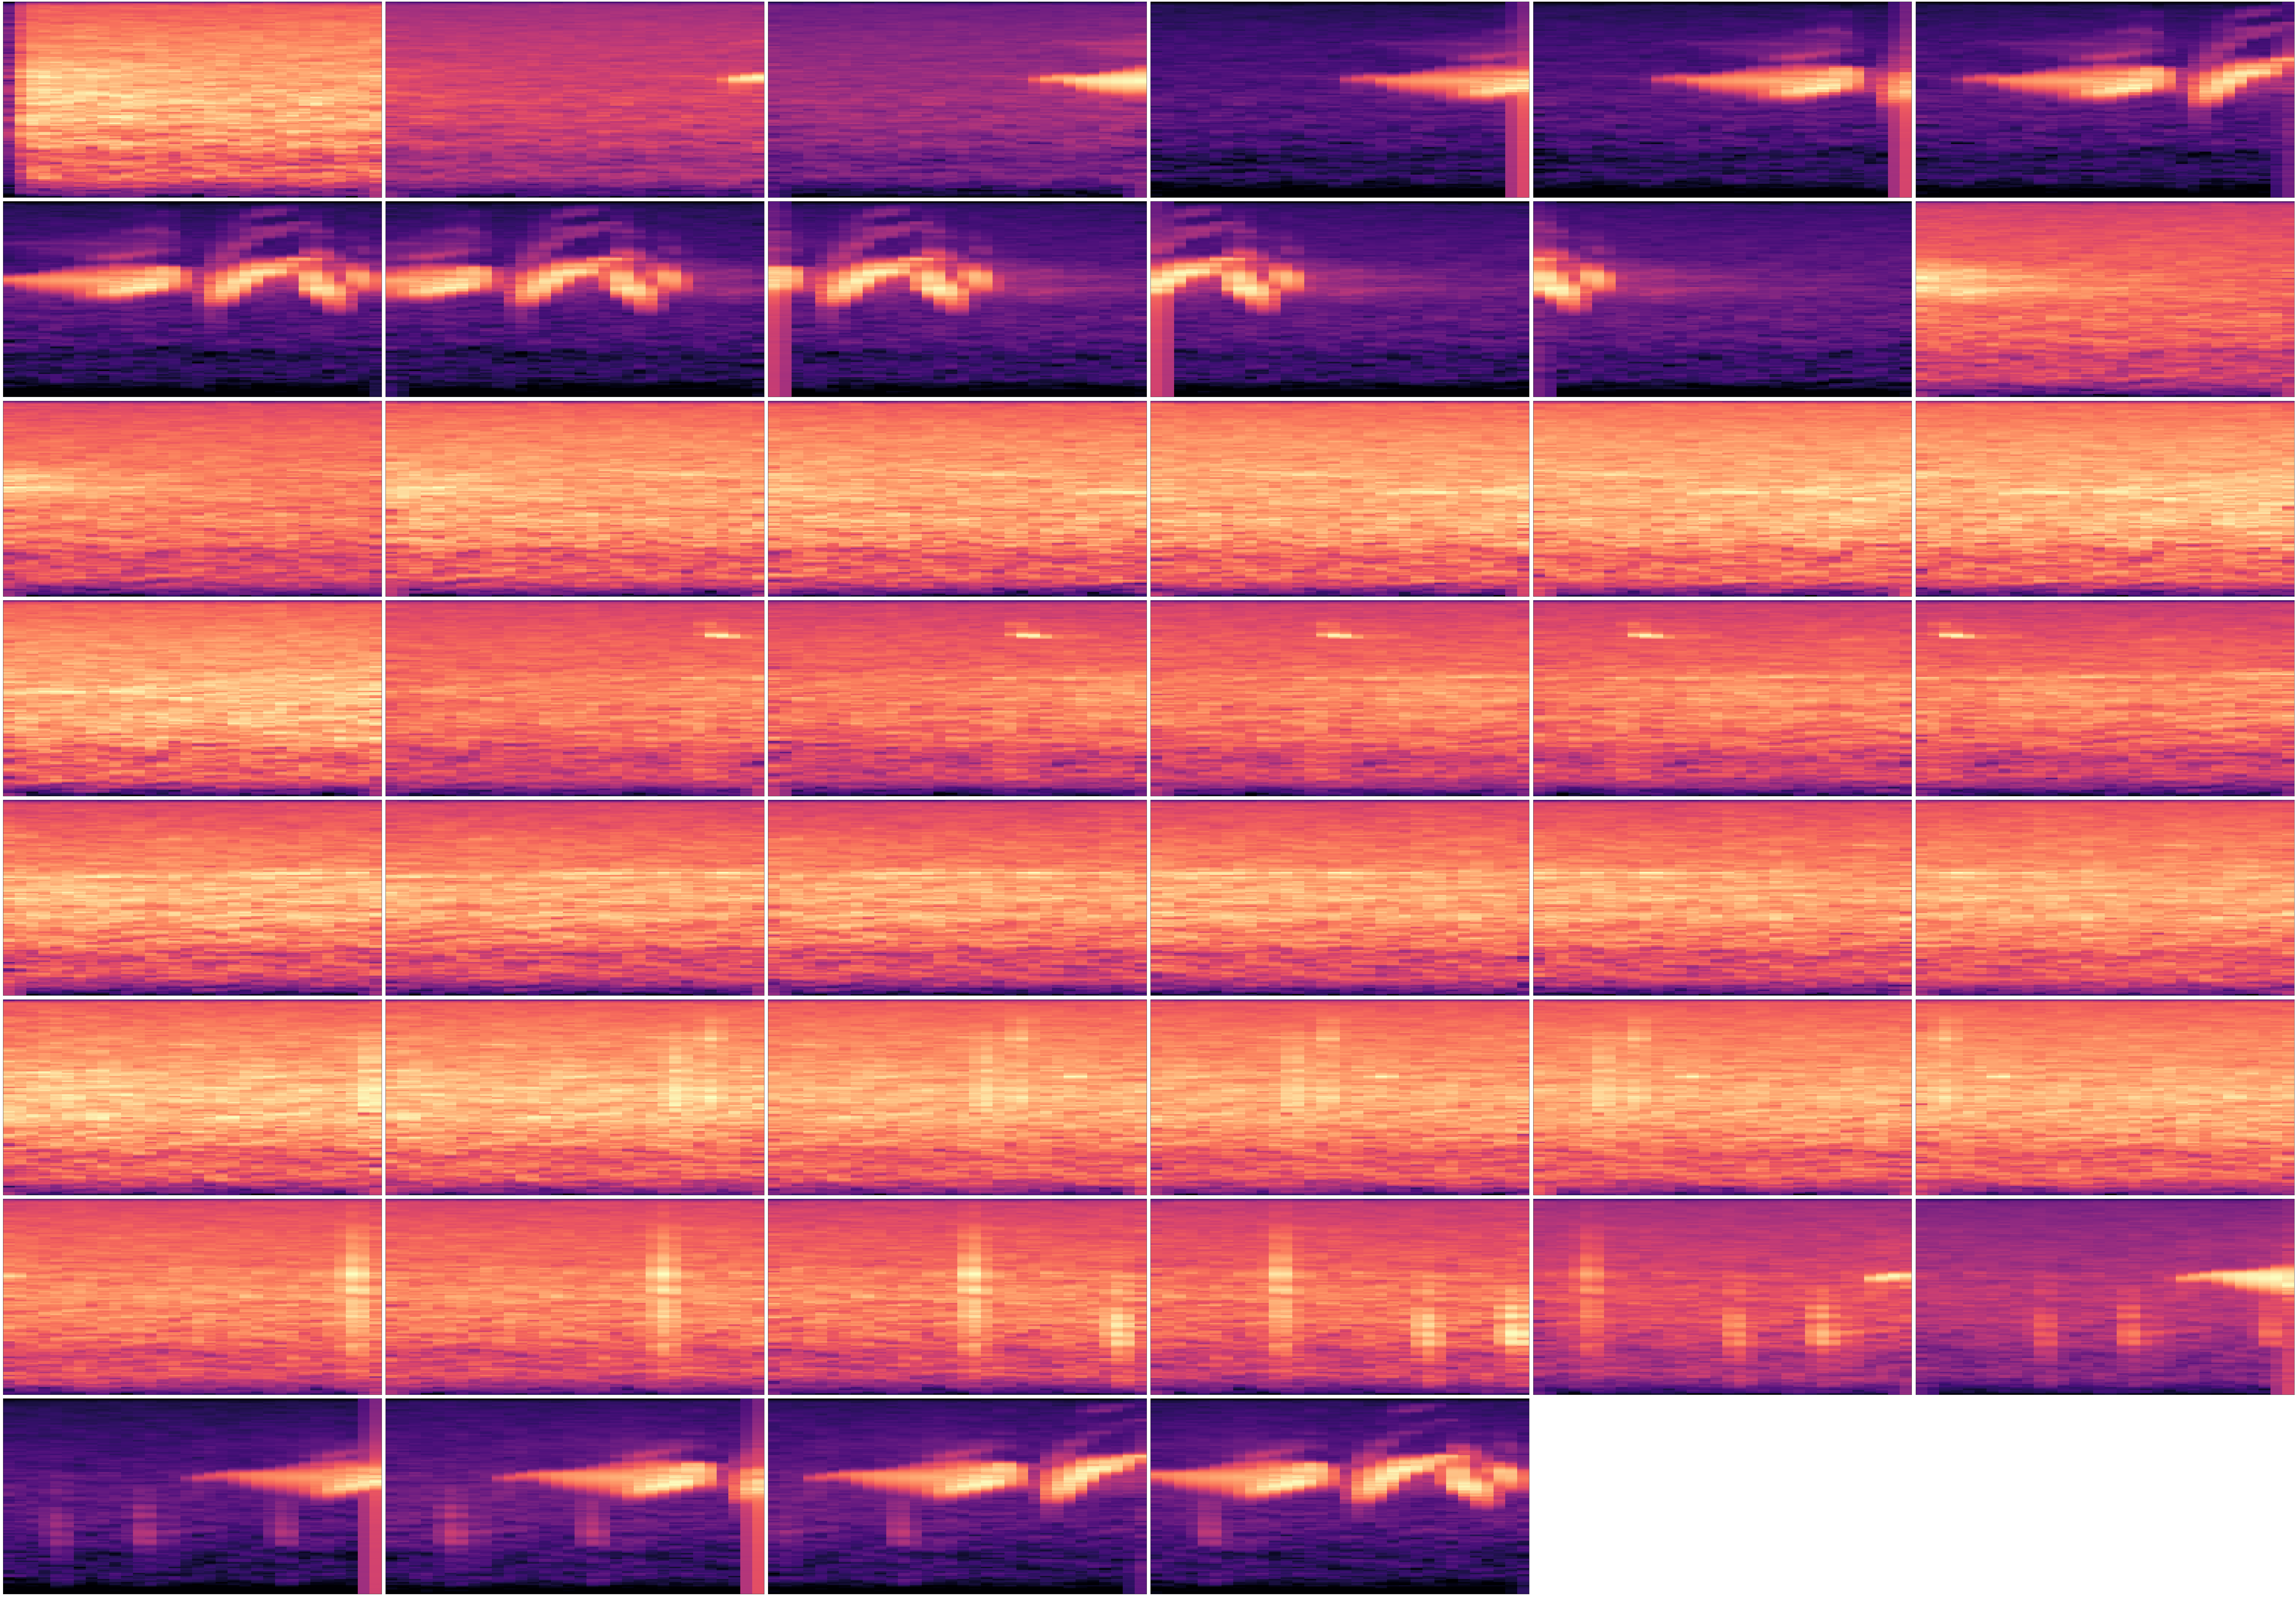

In [30]:
num_windows = 46
max_plt_per_row = 6
plt.figure(figsize=(int(2.5*num_windows), 10*(num_windows//max_plt_per_row +1))) 
for i in range(num_windows):
    plt.subplot(num_windows//max_plt_per_row +1, max_plt_per_row, i+1)
    win_ind = i
    S = spectr_clipped_slide[idx_spectr][i,:,:]
    librosa.display.specshow(np.flipud(S))
    plt.tight_layout()

plt.show()